![Astrofisica Computacional](../logo.PNG)

## Potencial Gravitacional en el Interior de una Estrella Esferica con Densidad Constante
---

Eduard Larrañaga (ealarranaga@unal.edu.co)

---

En este ejercicio se modelará el potencial gravitacional en el interior de una estrella esféricamente simétrica con una densidad de masa constante al resolver la ecuación de Poisson correspondiente. Aún cuando esta es una ecuación diferencial parcial, al considerar una distribución esféricamente simétrica el sistema se reduce a una ecuación diferencial ordinaria. 


Consideraremos la ecuación de Poisson

\begin{equation}
\nabla ^2 \phi (t,x,y,z) = 4\pi G \rho (t,x,y,z)
\end{equation}

donde $\phi(t,x,y,z)$ es el potencial gravitacional y $\rho(t,x,y,z)$ representa la densidad de masa. Utilizando un sistema de unidades con 

- Unidades de tiempo : años (yr)
- Unidades de masa : Masas solares($M_{\odot}$)
- Unidades de distancia : Unidades Astronómicas (au)

se tiene el valor $G=4\pi^2 \textrm{au}^3 \textrm{yr}^{-2} M_{\odot}^{-1}$.

Al imponer que el sistema es estático y tiene simetría esférica, la ecuación se transforma en

\begin{equation}
\frac{1}{r^2} \frac{d}{dr} \left( r^2 \frac{d\phi (r)}{dr} \right) = 4\pi G \rho (r)
\end{equation}

en donde las derivadas parciales se han convertido end erivadas totales debido a la dependencia de las funciones involucradas. En este problema particular, consideraremos que la densidad de masa es constante,

\begin{equation}
\rho = \textrm{constante}
\end{equation}

e impondremos las siguientes condiciones de frontera:

\begin{align}
\phi(0) =& 0 \\
\phi(R) =& - \frac{GM}{R}
\end{align}

donde $M$ y $R$ son la masa y el radio de la estrella. Tomaremos los valores obtenidos en un ejercicio anterior (en el caso de una enana blanca),

\begin{align}
M = &1.46 M_{\odot} \\
R = & 1539.54 \textrm{km} = 1.02911\times 10^{-5} \textrm{au}
\end{align}

y con ellos calculamos el valor constante de densidad

\begin{align}
\rho = &\frac{M}{\frac{4\pi}{3}R^3} = 3.1980\times 10^{14} M_{\odot} au^{-3}
\end{align}


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#### Constantes del Problema ####
G = 4*np.pi**2
M = 1.46 # Masas solares
R = 1.02911e-5 # au
V = (4*np.pi/3)*R**3 # Volumen de la estrella esferica
rho = M/V # Densidad constante
print(f'rho = {rho:.4e}')

rho = 3.1980e+14


## Potencial Gravitacional Externo

Antes de comenzar con el potencial interno, consideraremos la región externa en donde, debido a la simetría esférica, tomará la forma

\begin{equation}
\phi_{ext}(r) = - \frac{GM}{r}
\end{equation}

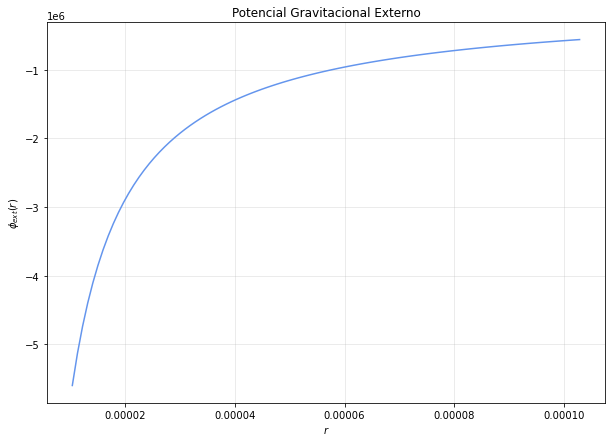

In [3]:
def phi_ext(r):
    return - G*M/r

radius = np.linspace(R, 10*R, 100)

# Figura potencial externo vs r
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(radius, phi_ext(radius), color='cornflowerblue')
ax.set_title('Potencial Gravitacional Externo')
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$\phi _{ext}(r)$')
ax.grid(alpha=0.3)

plt.show()

---

## Potencial Gravitacional Interno

Para obtener el potencial interno, es necesario integrar la ecuación diferencial

\begin{equation}
\frac{1}{r^2} \frac{d}{dr} \left( r^2 \frac{d\phi (r)}{dr} \right) = 4\pi G \rho (r).
\end{equation}

Ya que vamos a utilizar el Método Shooting, se implementará un interador Runge-Kutta 4 y por ello debemos re-escribir la relación diferencial como un sistema de ecuaciones de primer orden,

\begin{align}
\frac{d\phi}{dr} = & \frac{1}{r^2} u\\
\frac{du}{dr} = & 4 \pi G r^2 \rho
\end{align}

---
Primero implementaremos la función con las ecuaciones diferenciales y el Método RK4

In [4]:
# Ecuaciones diferenciales
def ODE(r, q):
    '''
    q: Variables involucradas
    phi = q[0]
    u = q[1]
    '''
    phi = q[0]
    u = q[1]

    f = np.zeros(2)
    f[0] = u/(r**2)
    f[1] = 4*np.pi*G*rho*r**2
    return f



# Método Runge-Kutta 4
def RK4(ODE, r, dr, q):
    '''
    ------------------------------------------
    RK4(ODE, r, dr, q):
    ------------------------------------------
    4th Order Runge-Kutta method for solving 
    a system of ODEs.
    Arguments:
    ODE: function defining the system of ODEs
    ------------------------------------------
    '''
    newq = np.zeros(2)
    k1 = dr*ODE(r, q)
    k2 = dr*ODE(r + dr/2, q + k1/2)
    k3 = dr*ODE(r + dr/2, q + k2/2)
    k4 = dr*ODE(r + dr, q + k3)
    newq = q + (k1 + 2*k2 + 2*k3 + k4)/6

    return newq


Ahora, creamos la malla de integración y proporcionamos una condición inicial adecuada. En este caso conocemos el valor del potencial en el centro de la estrella, pero no sabemos el valor de su primera derivada allí, i.e. $\frac{d\phi}{dr} = \frac{u}{r^2}$. 

Por ello, debemos considerar un "ansatz" para este valor para proceder con la integración. De esta forma supondremos:

\begin{align}
\phi(0) =& 0 \\
\frac{d\phi}{dr} =& z.
\end{align}

Nótese que la malla espacial para la discretización no inicia en $r_0=0$ sino en un valor muy pequeño $r_0 = 1 \times 10^{-5}$ (con el fin de evitar valores divergentes dentro de las ecuaciones)

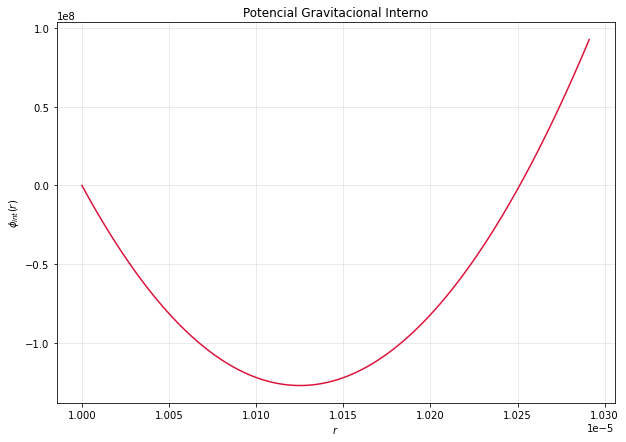

In [8]:
# Establece el grid para la integración
npoints = 100
r_int = np.linspace(1e-5, R, npoints)
dr = radius[1]-radius[0]

# Establece las variables
q = np.zeros([npoints,2]) 

#### Condiciones Iniciales ####
z = - 700
q[0,0] = 0.
q[0,1]  = z # Ansatz

for i in range(len(r_int)-1):
    q[i+1] = RK4(ODE, r_int[i], dr, q[i])
    


# Figura potencial interno vs r
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(r_int, q[:,0], color='crimson')
ax.set_title('Potencial Gravitacional Interno')
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$\phi_{int}(r)$')
ax.grid(alpha=0.3)

plt.show()

Ahora bien, ya que el problema original posee valores de condición de frontera, es necesario verificar que la solución obtenida cumple con la condición dada en la superficie de la estrella,

\begin{align}
\phi(R) =& - \frac{GM}{R}
\end{align}.

El valor obtenido en la integración es

In [9]:
q[-1,0]

92584800.99694648

peor el valor que debe obternerse es

In [10]:
phi_s = -G*M/R
phi_s

-5600809.408358859

## Método Shooting

Debido a que el ansatz $\left. \frac{d\phi}{dr} \right| _{r=0} = z$ no produjo el valor esperado en la superficie de la estrella, debemos proceder a cambiar el valor de este parámetro.

Para conseguir el valor adecuado para $z$, definimos la función

\begin{equation}
F(z) = \phi_{int}(R,z) - \phi_s(R)
\end{equation}

donde $\phi_{int}(r,z)$ es la función potencial obtenida por integración, la cual depende del ansatz elegido $z$.

A continuación implementamos esta función,

In [13]:
# Establece el grid para la integración
npoints = 100
r_int = np.linspace(1e-5, R, npoints)
dr = radius[1]-radius[0]

 
def F(z):
    # Establece las variables
    qz = np.zeros([npoints,2])
    #### Condiciones Iniciales ###
    qz[0,0] = 0.
    qz[0,1]  = z # Ansatz
    for i in range(len(r_int)-1):
        qz[i+1] = RK4(ODE, r_int[i], dr, qz[i])
    return qz[-1,0] - phi_s

delta = F(-800)
delta

15762425.641259627

y ahora utilizaremos la función [scipy.optimiza.root_scalar](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root_scalar.html#scipy.optimize.root_scalar) para buscar la raiz de $F(z)$, es decir, el valor $z=z_{root}$ que da como resultado $F(z_{root}) = 0$ y por lo tanto, el potencial gravitacional cumplirá con la condición de frontera en la superficie de la estrella.

Para utilizar esta función, se inicia con dos valores iniciales de la variable 
$z$ y se utiliza el método de la secante para buscar el cero de la función.

In [14]:
from scipy.optimize import root_scalar

sol = root_scalar(F, x0=-600, x1=-700)
sol

      converged: True
           flag: 'converged'
 function_calls: 3
     iterations: 2
           root: -819.123776503399

Como se puede observar del resultado, el procedimiento converge y dió como resultado el valor de $z$

In [15]:
z_root = sol.root
z_root

-819.123776503399

Fácilmente se puede comprobar que, en efecto, esta es una raiz de la función,

In [16]:
delta = F(z_root)
delta

-1.2200325727462769e-07

Con esta informción, podemos proceder a realizar la integración para obtener el potencial interno,

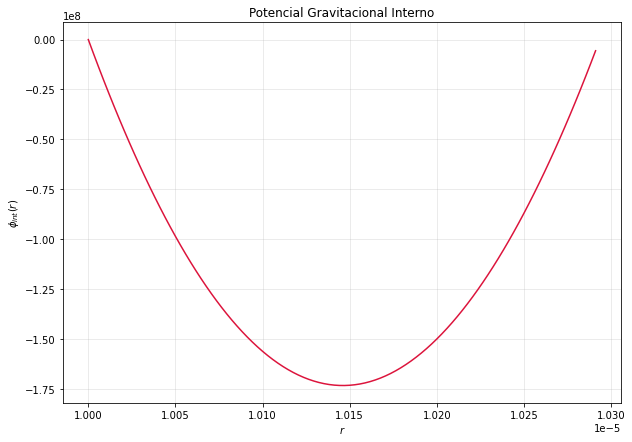

In [17]:
# Establece el grid para la integración
npoints = 100
r_int = np.linspace(1e-5, R, npoints)
dr = radius[1]-radius[0]

# Establece las variables
q_int = np.zeros([npoints,2]) 

#### Condiciones Iniciales ####

q_int[0,0] = 0.
q_int[0,1]  = z_root # True Initial Value

for i in range(len(r_int)-1):
    q_int[i+1] = RK4(ODE, r_int[i], dr, q_int[i])
    


# Figura potencial interno vs r
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(r_int, q_int[:,0], color='crimson')
ax.set_title('Potencial Gravitacional Interno')
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$\phi_{int}(r)$')
ax.grid(alpha=0.3)

plt.show()

y a visualizar el potencial gravitacional en las regiones interna y externa.

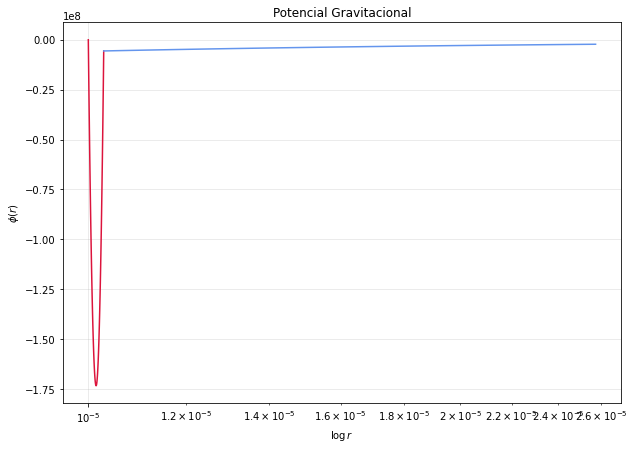

In [18]:
def phi_ext(r):
    return - G*M/r

r_ext = np.linspace(R, 2.5*R, 100)

# Figura potencial externo vs r
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(r_int, q_int[:,0], color='crimson')
ax.plot(r_ext, phi_ext(r_ext), color='cornflowerblue')
ax.set_title('Potencial Gravitacional')
ax.set_xscale('log')
ax.set_xlabel(r'$\log r$')
ax.set_ylabel(r'$\phi(r)$')
#ax.set_ylim(-0.2e8,0)
ax.grid(alpha=0.3)

plt.show()

\begin{equation}
\frac{1}{r^2} \frac{d}{dr} \left( r^2 \frac{d\phi (r)}{dr} \right) = 4\pi G \rho
\end{equation}

\begin{equation}
\frac{d}{dr} \left( r^2 \frac{d\phi (r)}{dr} \right) = 4\pi G \rho r^2
\end{equation}

\begin{equation}
 r^2 \frac{d\phi (r)}{dr}  = \frac{4\pi}{3} G \rho r^3 + C
\end{equation}

\begin{equation}
 \frac{d\phi (r)}{dr}  = \frac{4\pi}{3} G \rho r + \frac{C}{r^2}
\end{equation}

\begin{equation}
\phi (r)   = \frac{2\pi}{3} G \rho r^2 - \frac{C}{r} + K
\end{equation}

\begin{equation}
\phi (r)   = \frac{4\pi}{3} \frac{G}{2} \rho r^2 - \frac{C}{r} + K
\end{equation}